In [40]:
## Import necessary packages
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

In [41]:
## Store data in Pandas Dataframe
## Data: Drug-Drug Interactions involving antineoplastic (cancer treating) and immunomodulating (affecting the immune system) agents drugs	
url = 'http://ddinter.scbdd.com/static/media/download/ddinter_downloads_code_L.csv'
ddi_data = pd.read_csv(url) 

In [42]:
drugs_a_unique = ddi_data['Drug_A'].unique()
drugs_b_unique = ddi_data['Drug_B'].unique()
all_drugs = []
for x in drugs_a_unique: 
  all_drugs.append(x)
for x in drugs_b_unique: 
  all_drugs.append(x)
all_drugs_df = pd.DataFrame(all_drugs, columns = ['Drug Name'])
drugs_unique = all_drugs_df['Drug Name'].unique()

In [4]:
## Create list of weighted edges to signify interactions and give greater importance to more severe interactions
interacting_drugs = ddi_data[ddi_data['Level'] != 'Unknown']
weights = []
for x in interacting_drugs['Level']:
  if x == 'Major':
    weights.append(3)
  elif x == 'Moderate':
    weights.append(2)
  elif x == 'Minor':
    weights.append(1)
drug_edges = [
                 [x, y, z] for x, y, z
                 in zip(interacting_drugs['Drug_A'], 
                        interacting_drugs['Drug_B'], 
                        weights)
                 ]

In [5]:
## Create weighted Networkx graph
G = nx.Graph()
G.add_nodes_from(drugs_unique)
G.add_weighted_edges_from(drug_edges)

In [6]:
## Install package node2vec
## node2vec is an algorithmic framework for representational learning on graphs. 
## Given any graph, it can learn continuous feature representations for the nodes, which can then be used for various downstream machine learning tasks. 
!pip install node2vec
from node2vec import Node2Vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for node2vec: filename=node2vec-0.4.3-py3-none-any.whl size=5980 sha256=69de6b717c5f0f6763c6058d74d508c9869305dc7288aa3f31c1220ad3d6d1a3
  Stored in directory: /root/.cache/pip/wheels/07/62/78/5202cb8c03cbf1593b48a8a442fca8ceec2a8c80e22318bae9
Successfully built node2vec


In [7]:
## Employ Node2Vec on the weighted graph
## Create embeddings. Parameters indicate to create an array with 50 components based on 5 walks each with a length of 80 for each node/drug
node2vec = Node2Vec(G, dimensions=50, num_walks=5)
## Fit the walks to a model using skipgram/Word2Vec
model = node2vec.fit()
## Translate to a dataframe of the vectors/arrays that we can use in the model
emb_df = (
    pd.DataFrame(
        [model.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes
    )
)

Computing transition probabilities:   0%|          | 0/1699 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 5/5 [01:09<00:00, 13.88s/it]


In [8]:
## Create X matrix with only interacting drugs' embeddings
X = []
for x, y in zip(interacting_drugs['Drug_A'], interacting_drugs['Drug_B']):
  emb_con_2 = np.concatenate((emb_df.loc[x].to_numpy(), emb_df.loc[y].to_numpy()))
  X.append(emb_con_2)

In [9]:
## Create a y-matrix with the level of interaction
y = []
for x in interacting_drugs['Level']:
  y.append(x)

In [10]:
## Split data into training and testing
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

In [11]:
## Import models to test
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [12]:
## Import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

KNN Accuracy: 0.8322888518369459
KNN Precision: [0.74790677 0.80519481 0.86309143]
KNN Recall: [0.6807415  0.61184211 0.90519698]
KNN F1 score: [0.71274531 0.6953271  0.88364291]


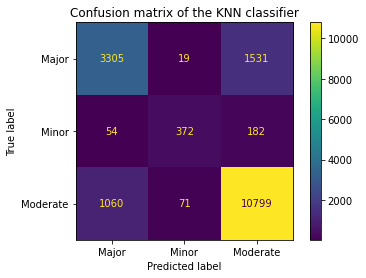

In [39]:
## K Nearest Neighbors Model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)

score = accuracy_score(y_test, predictions)
print('KNN Accuracy: ' + str(score))
precision = precision_score(y_test, predictions, average=None)
print('KNN Precision: ' + str(precision))
recall = recall_score(y_test, predictions, average=None)
print('KNN Recall: ' + str(recall))
f1 = f1_score(y_test, predictions, average=None)
print('KNN F1 score: ' + str(f1))

con_mat = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(con_mat, display_labels = knn.classes_)
disp.plot()
plt.title('Confusion matrix of the KNN classifier')
plt.show()

In [ ]:
## Hyperparameter tuning - number of neighbors, try weights='distance' once
## probably not as good since high dimensions and many samples
accs = []
for i in range(1,16):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train, y_train)
  predictions = knn.predict(X_test)
  score = accuracy_score(y_test, predictions)
  accs.append(score)

plt.figure(figsize=(10,6))
plt.plot(range(1, 16), accs)

## max accuracy around 83.5%-ish

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLP Accuracy: 0.919565342379118
MLP Precision: [0.89431068 0.78453039 0.93534589]
MLP Recall: [0.86446962 0.70065789 0.95314334]


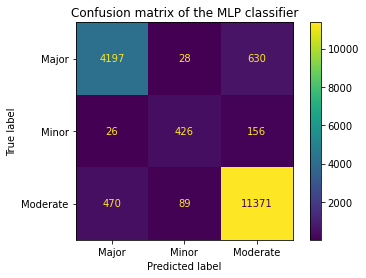

In [14]:
## Multi-Layer Perceptron Model
mlp = MLPClassifier(alpha=0.0001,max_iter=200)
mlp.fit(X_train, y_train)
predictions = mlp.predict(X_test)

score = accuracy_score(y_test, predictions)
print('MLP Accuracy: ' + str(score))
precision = precision_score(y_test, predictions, average=None)
print('MLP Precision: ' + str(precision))
recall = recall_score(y_test, predictions, average=None)
print('MLP Recall: ' + str(recall))

con_mat = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(con_mat, display_labels = mlp.classes_)
disp.plot()
plt.title('Confusion matrix of the MLP classifier')
plt.show()

In [ ]:
## Hyperparameter tuning - number of hidden layers, maybe try activation='tanh' or something else, alpha, max_iter
accs = []
for i in range(1,8):
  mlp = MLPClassifier(max_iter=100*i)
  mlp.fit(X_train, y_train)
  predictions = mlp.predict(X_test)
  score = accuracy_score(y_test, predictions)
  accs.append(score)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLP Accuracy: 0.9162881619042144
MLP Precision: [0.89560321 0.83010753 0.92730079]
MLP Recall: [0.85169928 0.63486842 0.95691534]


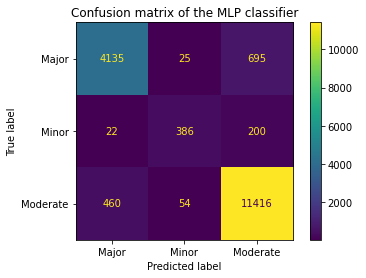

In [15]:
mlp = MLPClassifier(alpha=0.0001,max_iter=200, activation='logistic')
mlp.fit(X_train, y_train)
predictions = mlp.predict(X_test)

score = accuracy_score(y_test, predictions)
print('MLP Accuracy: ' + str(score))
precision = precision_score(y_test, predictions, average=None)
print('MLP Precision: ' + str(precision))
recall = recall_score(y_test, predictions, average=None)
print('MLP Recall: ' + str(recall))

con_mat = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(con_mat, display_labels = mlp.classes_)
disp.plot()
plt.title('Confusion matrix of the MLP classifier')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(accs)

## max accuracy at 200 iterations, about 91.72%-ish

SVM Accuracy: 0.9155407347783591
SVM Precision: [0.92448405 0.96825397 0.91098737]
SVM Recall: [0.81194645 0.60197368 0.9736798 ]


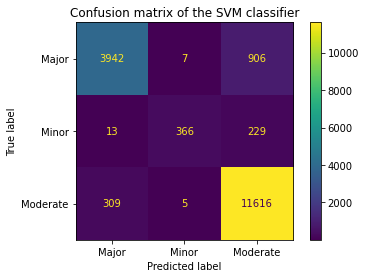

In [16]:
## Support Vector Model
svm = SVC(kernel='poly',degree=4)
svm.fit(X_train, y_train)
predictions = svm.predict(X_test)

score = accuracy_score(y_test, predictions)
print('SVM Accuracy: ' + str(score))
precision = precision_score(y_test, predictions, average=None)
print('SVM Precision: ' + str(precision))
recall = recall_score(y_test, predictions, average=None)
print('SVM Recall: ' + str(recall))

con_mat = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(con_mat, display_labels = svm.classes_)
disp.plot()
plt.title('Confusion matrix of the SVM classifier')
plt.show()

In [ ]:
## Hyperparameter tuning - C, try kernel='poly' and change degree
accs = []
for i in range(1,7):
  svm = SVC(kernel='poly', degree=i)
  svm.fit(X_train, y_train)
  predictions = svm.predict(X_test)
  score = accuracy_score(y_test, predictions)
  accs.append(score)

plt.figure(figsize=(10,6))
plt.plot(range(1, 7), accs)

## seems like max is at 4 with >90% accuracy

Decision Tree Accuracy: 0.8626458920255275
Decision Tree Precision: [0.79011842 0.61295419 0.90591806]
Decision Tree Recall: [0.79711637 0.63815789 0.9007544 ]


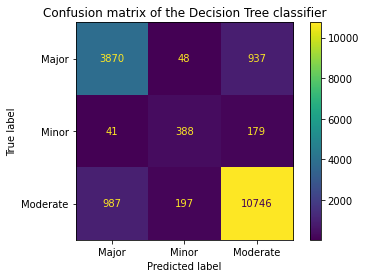

In [36]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=41)
dt.fit(X_train, y_train)
predictions = dt.predict(X_test)

score = accuracy_score(y_test, predictions)
print('Decision Tree Accuracy: ' + str(score))
precision = precision_score(y_test, predictions, average=None)
print('Decision Tree Precision: ' + str(precision))
recall = recall_score(y_test, predictions, average=None)
print('Decision Tree Recall: ' + str(recall))

con_mat = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(con_mat, display_labels = dt.classes_)
disp.plot()
plt.title('Confusion matrix of the Decision Tree classifier')
plt.show()

In [43]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [44]:
emb_df.to_csv('emb_df.csv',index_label=False)
!cp emb_df.csv "drive/My Drive/"